# Nightvision

In this challenge, the aim is to take infrared images taken from a satellite at all times of day and night, and predict the visible image corresponding to the IR observations.

---

This challenge is based on the challenge of the same name from the Climate Informatics 2020 hackathon \[Jones and Lguensat, 2020\] and the solutions presented in Harder et al. \[2020]

In [1]:
import pathlib
import urllib
import numpy as np
import matplotlib.pyplot as plt

## 1. Download and read data

First, we need to locate and download the data from the Zenodo repository if it is not already present. This will require 3.2GB of storage, and takes about 2 minutes in total

TODO: add files to common path on jasmin

TODO: create new training dataset with a wider variety of scenes?

In [2]:
data_path = pathlib.Path("../../data/2-nightvision")
if not data_path.exists():
    data_path.mkdir()

In [3]:
cloudtop_file = data_path / "X_train_CI20.npy"
if not cloudtop_file.exists():
    urllib.request.urlretrieve(
        "https://zenodo.org/records/4061336/files/X_train_CI20.npy", 
        cloudtop_file
    )

In [4]:
truecolour_file = data_path / "Y_train_CI20.npy"
if not truecolour_file.exists():
    urllib.request.urlretrieve(
        "https://zenodo.org/records/4061336/files/Y_train_CI20.npy", 
        truecolour_file
    )

Now we can open both files and check that the shape of both match. The two files should contain 8423 127x127 3 channel images each.

In [5]:
cloudtop = np.load(cloudtop_file).astype(int)
truecolour = np.load(truecolour_file).astype(int)
truecolour.shape, cloudtop.shape

((8423, 127, 127, 3), (8423, 127, 127, 3))

Now lets visualise a selection of the images:

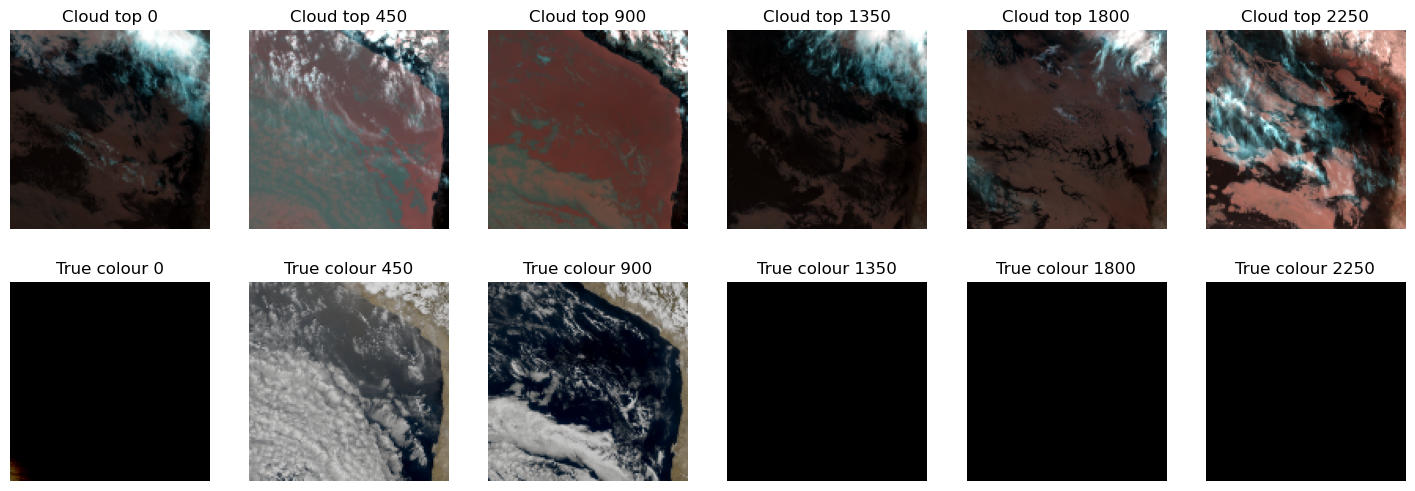

In [6]:
fig, axes = plt.subplots(2, 6, figsize=(18,6))

for i in range(6):
    axes[0, i].imshow(cloudtop[i*450])
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*450}')
    axes[1, i].imshow(truecolour[i*450])
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'True colour {i*450}')

As you can see, some of the true colour images are completely blank. The dataset contains a image pairs from all times of day, including at night. This will be the first issue we need to address when preparing the data for training

## 2. Data cleaning

The first step in the processing pipeline is to clean the incoming data to ensure we have a good training dataset. To remove the nighttime images we can simply remove all image pairs where all of the visible pixels are zero:

In [7]:
wh_nighttime = np.all(
    truecolour==0, axis=(1,2,3)
)

print(f'Total nighttime images: {wh_nighttime.sum()}')

Total nighttime images: 3906


In [8]:
# Now crop the truecolour and cloudtop arrays using the nighttime image array:

truecolour_daytime = truecolour[np.logical_not(wh_nighttime)]
cloudtop_daytime = cloudtop[np.logical_not(wh_nighttime)]
truecolour_daytime.shape, cloudtop_daytime.shape

((4517, 127, 127, 3), (4517, 127, 127, 3))

Now let's visualise the results:

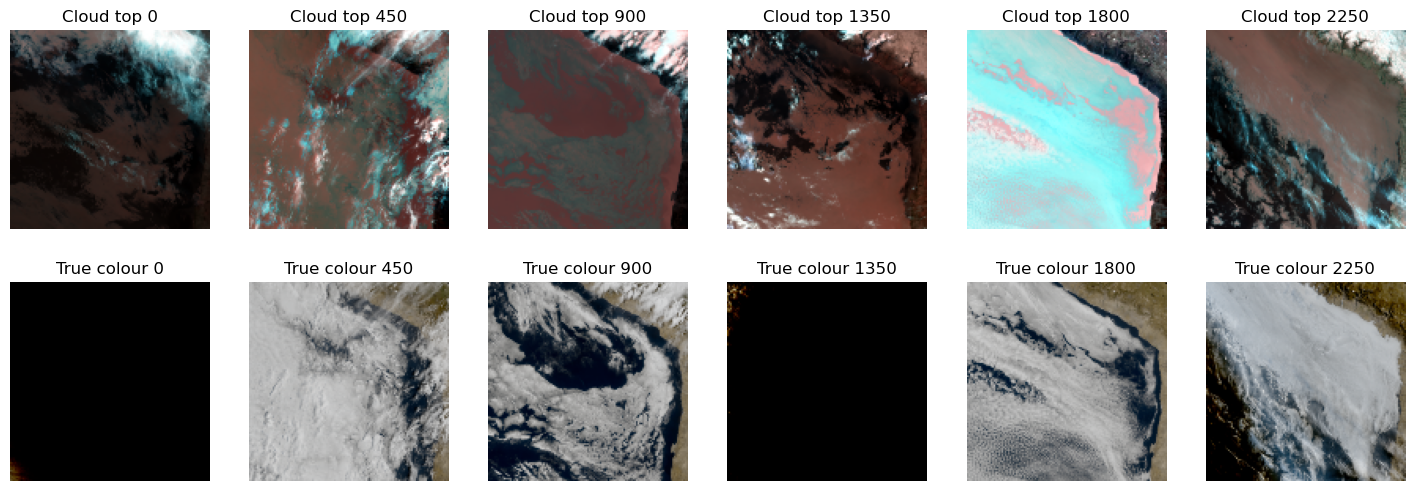

In [9]:
fig, axes = plt.subplots(2, 6, figsize=(18,6))

for i in range(6):
    axes[0, i].imshow(cloudtop_daytime[i*450])
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*450}')
    axes[1, i].imshow(truecolour_daytime[i*450])
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'True colour {i*450}')

While this has increased the proportion of daytime images, there are still a number of image pairs where the visible image is mostly darkness. Now it's your turn to improve the data cleaning to ensure that we have a good quality dataset for model training while maintaining the size of the dataset as much as possible

# Exercises:
1. Plot histograms of the red, green and blue channels for the truecolour images. What might be a good cutoff values for pixels to be considered in darkness?
2. Rather than requiring all pixels to be in darkness to be considered nighttime, a better threshold might be if more than 50% of pixels are dark. Implement this requirement to create a new nighttime mask.
3. Experiment with different pixel values that are considered dark, and different percentage of the image to be considered dark. How do different choices affect the number of image pairs remaining in the training dataset? What do you think will be the best compromise?
4. Apply your chosen best thresholds to filter the daytime images

Extension questions:

5. What other data cleaning approaches might be useful for removing night time images?
6. What other data quality issues might be present in earth observation images? How might you address these?

Text(0.5, 1.0, 'True colour histogram by channel')

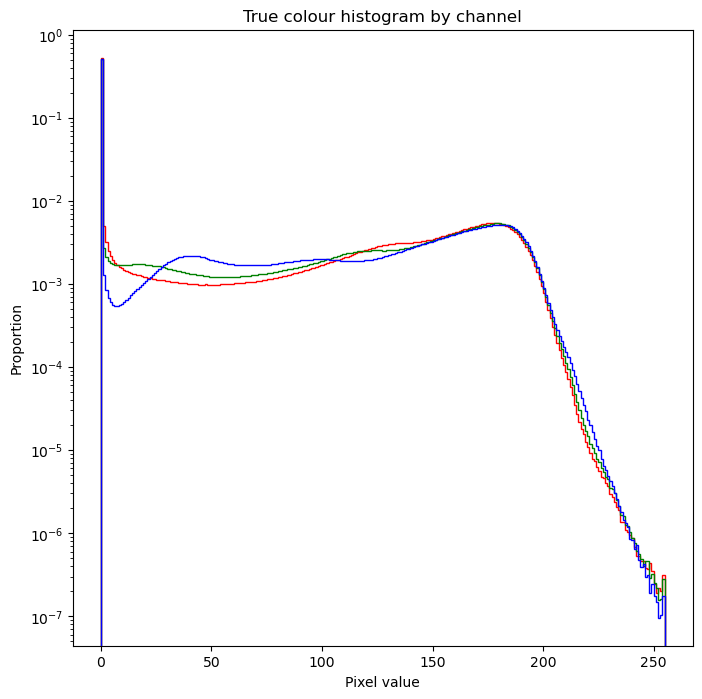

In [10]:
# Exercise answers:
fig, ax = plt.subplots(figsize=(8,8))

h_red= ax.hist(truecolour[...,0].ravel(), bins=np.arange(256), density=True, color="red", histtype="step")
h_green = ax.hist(truecolour[...,1].ravel(), bins=np.arange(256), density=True, color="green", histtype="step")
h_blue = ax.hist(truecolour[...,2].ravel(), bins=np.arange(256), density=True, color="blue", histtype="step")

ax.set_yscale("log")
ax.set_xlabel("Pixel value")
ax.set_ylabel("Proportion")
ax.set_title("True colour histogram by channel")

Between 5 and 10 seems like a good value

In [11]:
# Exercise answers 2 mask by proportion:
wh_50percent_nighttime = np.mean(
    truecolour==0, axis=(1,2,3)
) > 0.5
print(f'Total nighttime images: {wh_50percent_nighttime.sum()}')

Total nighttime images: 4331


In [12]:
# Now lets span a range of values for each
for percentage in [1, 25, 50, 75, 99]:
    for threshold in [0, 5, 10, 20]:
        print(f'Threshold={threshold}, percentage={percentage}%, removed images={
            (np.mean(
                truecolour<=threshold, axis=(1,2,3)
            ) > (percentage/100)).sum()
        }')

Threshold=0, percentage=1%, removed images=6227
Threshold=5, percentage=1%, removed images=6821
Threshold=10, percentage=1%, removed images=7117
Threshold=20, percentage=1%, removed images=7559
Threshold=0, percentage=25%, removed images=4411
Threshold=5, percentage=25%, removed images=4459
Threshold=10, percentage=25%, removed images=4519
Threshold=20, percentage=25%, removed images=4691
Threshold=0, percentage=50%, removed images=4331
Threshold=5, percentage=50%, removed images=4344
Threshold=10, percentage=50%, removed images=4355
Threshold=20, percentage=50%, removed images=4372
Threshold=0, percentage=75%, removed images=4244
Threshold=5, percentage=75%, removed images=4256
Threshold=10, percentage=75%, removed images=4265
Threshold=20, percentage=75%, removed images=4274
Threshold=0, percentage=99%, removed images=4038
Threshold=5, percentage=99%, removed images=4064
Threshold=10, percentage=99%, removed images=4071
Threshold=20, percentage=99%, removed images=4080


Looks like the threshold value matters much less than the percentage of the image. At 1% dark pixels almost all of the dataset is gone! Let's pick 5 & 50% for a middle ground

In [13]:
wh_nighttime = np.mean(
    truecolour<=5, axis=(1,2,3)
) > 0.5

print(f'Total nighttime images: {wh_nighttime.sum()}')

Total nighttime images: 4344


In [14]:
# Now crop the truecolour and cloudtop arrays using the nighttime image array:

truecolour_daytime = truecolour[np.logical_not(wh_nighttime)]
cloudtop_daytime = cloudtop[np.logical_not(wh_nighttime)]
truecolour_daytime.shape, cloudtop_daytime.shape

((4079, 127, 127, 3), (4079, 127, 127, 3))

# 3. Splitting train, test and validation data

After data cleaning, an important step is to split the dataset into three separate train, test and validation datasets. A naive approch to this would be to cycle through the image pairs in sets of three, putting one into each of the datasets. However, we need to be wary that these images are also a time series, and that their is covariance between subsequent images and as a result we would be polluting our training dataset with data in the test and validation sets. Instead, let's simply split the dataset into three blocks:

In [15]:
block_length = truecolour_daytime.shape[0] // 3

truecolour_train = truecolour_daytime[:block_length]
truecolour_test = truecolour_daytime[block_length:2*block_length]
truecolour_validate = truecolour_daytime[2*block_length:]

cloudtop_train = cloudtop_daytime[:block_length]
cloudtop_test = cloudtop_daytime[block_length:2*block_length]
cloudtop_validate = cloudtop_daytime[2*block_length:]

print(f'Train: {cloudtop_train.shape[0]}, test: {cloudtop_test.shape[0]}, validate:{cloudtop_validate.shape[0]}')

Train: 1359, test: 1359, validate:1361


This produces three datasets of nearly equal length. However this is far from the best way to do this

# Exercises:

1. Over what time scales do you think earth observation images have significant covariance with each other? Does this vary with the location or phenomena you are observing?
2. What issues might we face with EO data by splitting our datasets into completely discrete sections for train, test and validate?
3. What is a better choice for the size of each chunk of dataset to ensure good coverage of the full time series without covariance?

Extension questions:

4. Download the file https://zenodo.org/records/4061336/files/Dates_train_CI20.npy which contains an array of dates corresponding the each image. Can you think of a better way to split the dataset using the date information?

In [16]:
# Let's use a block lenth of 100:
block_length = 24

truecolour_train = np.concatenate(
    [truecolour_daytime[i*block_length:(i+1)*block_length] for i in np.arange(0, truecolour_daytime.shape[0]//block_length + 1, 3)]
)
truecolour_test = np.concatenate(
    [truecolour_daytime[i*block_length:(i+1)*block_length] for i in np.arange(1, truecolour_daytime.shape[0]//block_length + 1, 3)]
)
truecolour_validate = np.concatenate(
    [truecolour_daytime[i*block_length:(i+1)*block_length] for i in np.arange(2, truecolour_daytime.shape[0]//block_length + 1, 3)]
)

cloudtop_train = np.concatenate(
    [cloudtop_daytime[i*block_length:(i+1)*block_length] for i in np.arange(0, cloudtop_daytime.shape[0]//block_length + 1, 3)]
)
cloudtop_test = np.concatenate(
    [cloudtop_daytime[i*block_length:(i+1)*block_length] for i in np.arange(1, cloudtop_daytime.shape[0]//block_length + 1, 3)]
)
cloudtop_validate = np.concatenate(
    [cloudtop_daytime[i*block_length:(i+1)*block_length] for i in np.arange(2, cloudtop_daytime.shape[0]//block_length + 1, 3)]
)

print(f'Train: {cloudtop_train.shape[0]}, test: {cloudtop_test.shape[0]}, validate:{cloudtop_validate.shape[0]}')

Train: 1368, test: 1367, validate:1344


# 4. Baseline

First, lets create a simple baseline to compare our models against. This is a naive solution based on analog methods (aka K-NN regression), but used here for regression instead of forecasting. The idea consists in taking for a test sample its nearest neighbor training cloud top image, then using its corresponding true colour image as the prediction.

In [17]:
# We can use the BallTree from scikit-learn to find nearest neighbours
from sklearn.neighbors import BallTree

# Now simply add all of our training dataset:
tree = BallTree(
    cloudtop_train.reshape((cloudtop_train.shape[0],-1)), 
    leaf_size=2
)

To use the model, we simply query the balltree object using the test image:

In [18]:
# k sets the number of nearest neighbours to return. Here we set it to 1
dist, prediction = tree.query(cloudtop_test[0].reshape((1,-1)), k=1) 

# Print the closest (and only) neighbour
print(f'Closest match: image {prediction[0][0]}, distance: {dist[0][0]}')

Closest match: image 206, distance: 4204.457039856633


Let's plot a few images to see what the predictions actually look like:

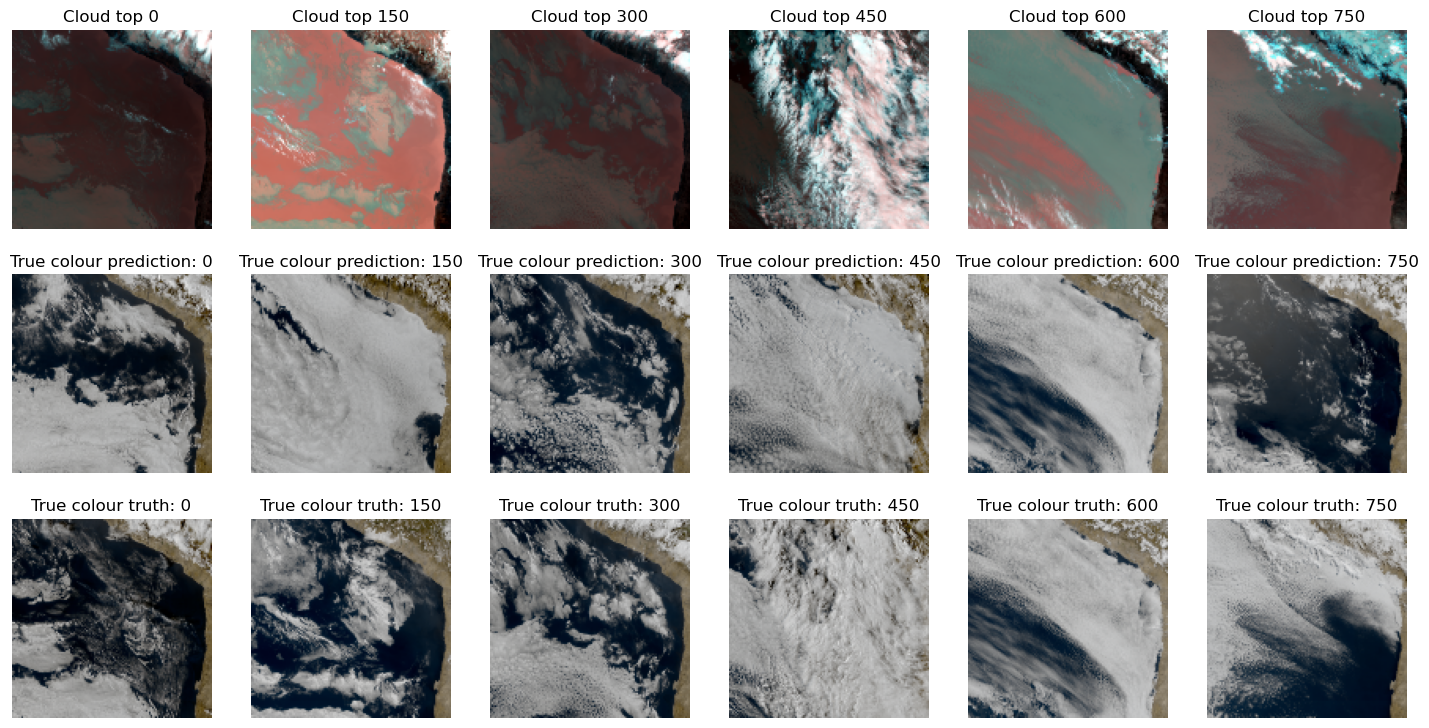

In [19]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))

for i in range(6):
    dist, prediction = tree.query(cloudtop_test[i*150].reshape((1,-1)), k=1) 
    axes[0, i].imshow(cloudtop_test[i*150])
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*150}')
    
    axes[1, i].imshow(truecolour_train[prediction[0][0]])
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'True colour prediction: {i*150}')

    axes[2, i].imshow(truecolour_test[i*150])
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f'True colour truth: {i*150}')


Surprisingly, some of these actually look quite close! However, as these all these predictions are real images, they look "right" to us even if they are not actually correct. How can we provide a more quantitative measure of the difference between the predictions and the true values?

## 5. Metrics

Metrics are important for evaluating any ML task. Here we will implement three different, commonly used metrics to see how they compare:

 - RMSE
 - PSNR
 - SSIM

In [20]:
import skimage.metrics

In [21]:
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity
# Define rmse
rmse = lambda img0, img1: mean_squared_error(img0, img1)**0.5
# Define options for ssim
from functools import partial
ssim = partial(structural_similarity, data_range=255, channel_axis=-1)

Now, let's plot the same examples again and see what the scores are:

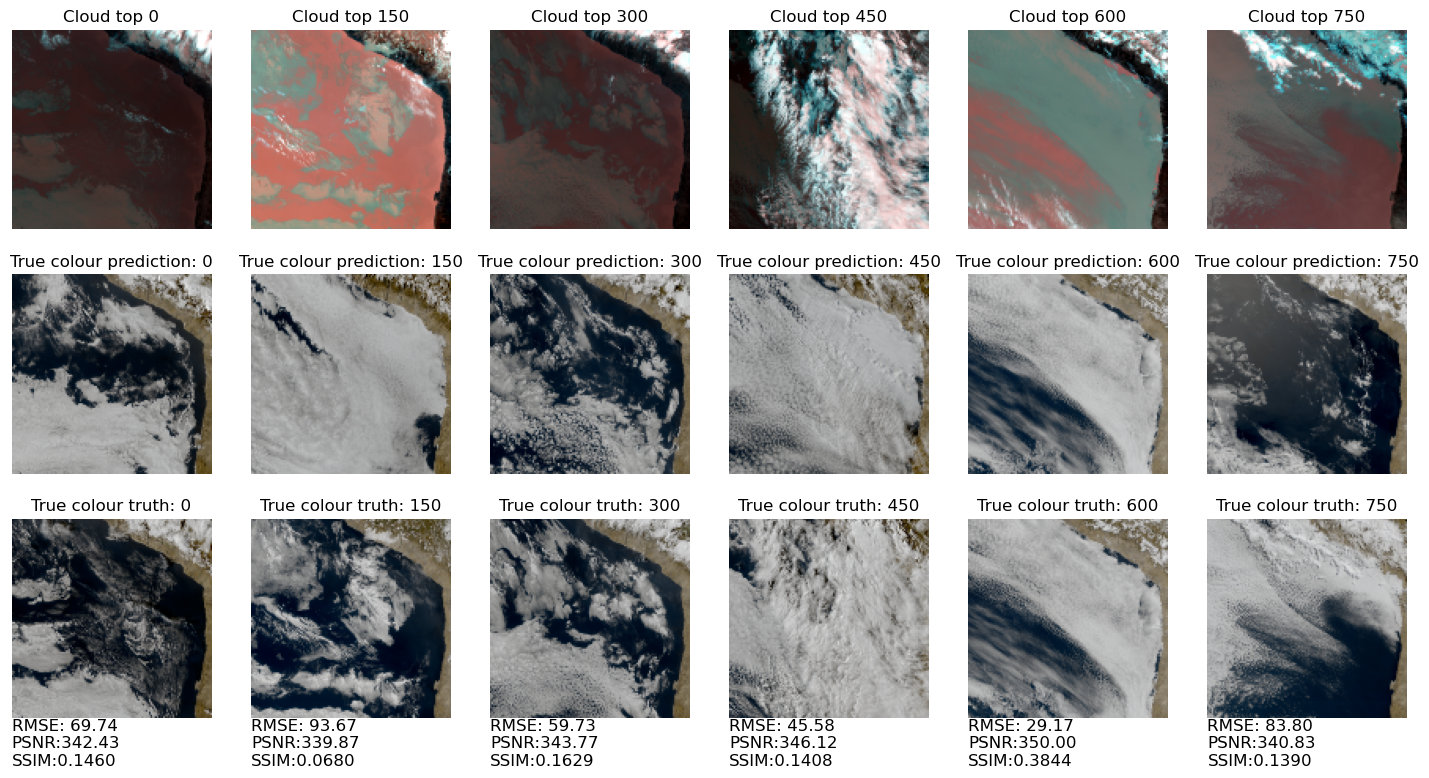

In [22]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))

for i in range(6):
    dist, prediction = tree.query(cloudtop_test[i*150].reshape((1,-1)), k=1) 
    pred_img = truecolour_train[prediction[0][0]]
    true_img = truecolour_test[i*150]

    
    axes[0, i].imshow(cloudtop_test[i*150])
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*150}')
    
    axes[1, i].imshow(pred_img)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'True colour prediction: {i*150}')

    axes[2, i].imshow(true_img)
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f'True colour truth: {i*150}')

    fig.text(
        *axes[2,i].get_position().bounds[0:2], 
        f'RMSE: {rmse(pred_img, true_img):.2f}' \
        f'\nPSNR:{psnr(pred_img, true_img):.2f}' \
        f'\nSSIM:{ssim(pred_img, true_img):.4f}',
        ha="left", va="top", fontsize=12
    )

For RMSE and PSNR, low scores are better. For SSIM, high scores are better. As we can see, none of the predictions score very well...

We can caluclate the metrics over the entire test set (limit to the first 200, for time), to see how well we are performing overall

In [23]:
test_rmse = []
test_psnr = []
test_ssim = []

for i in range(min(cloudtop_test.shape[0],200)):
    dist, prediction = tree.query(cloudtop_test[i].reshape((1,-1)), k=1) 
    pred_img = truecolour_train[prediction[0][0]]
    true_img = truecolour_test[i]

    test_rmse.append(rmse(pred_img, true_img))
    test_psnr.append(psnr(pred_img, true_img))
    test_ssim.append(ssim(pred_img, true_img))
    
print(f'Mean RMSE: {np.mean(test_rmse)}, \nMean PSNR: {np.mean(test_psnr)}, \nMean SSIM: {np.mean(test_ssim)}')

Mean RMSE: 70.68004096704657, 
Mean PSNR: 342.63036399461924, 
Mean SSIM: 0.13176229045986676


Overall, these poor results match what we saw in the individual images

## Exercises:

1. Compare each of the metrics to your own evaluation of the quality of the predictions. Which of the metrics do you think is the most useful for this task?
2. Instead of making a prediction based on one nearest neighbour, find the three nearest neighbours and average the result. Plot a few examples, and calculate the average RMSE, PSNR and SSIM of the predictions. Do you get better results? Do the predictions look realistic to you? What happens if you keep increasing the number of neighbours?

In [24]:
# Exercise answers:
def kNN_prediction(query_img, k):
    dists, predictions = tree.query(query_img.reshape((1,-1)), k=k) 
    return truecolour_train[predictions].squeeze().mean(0).astype(int)

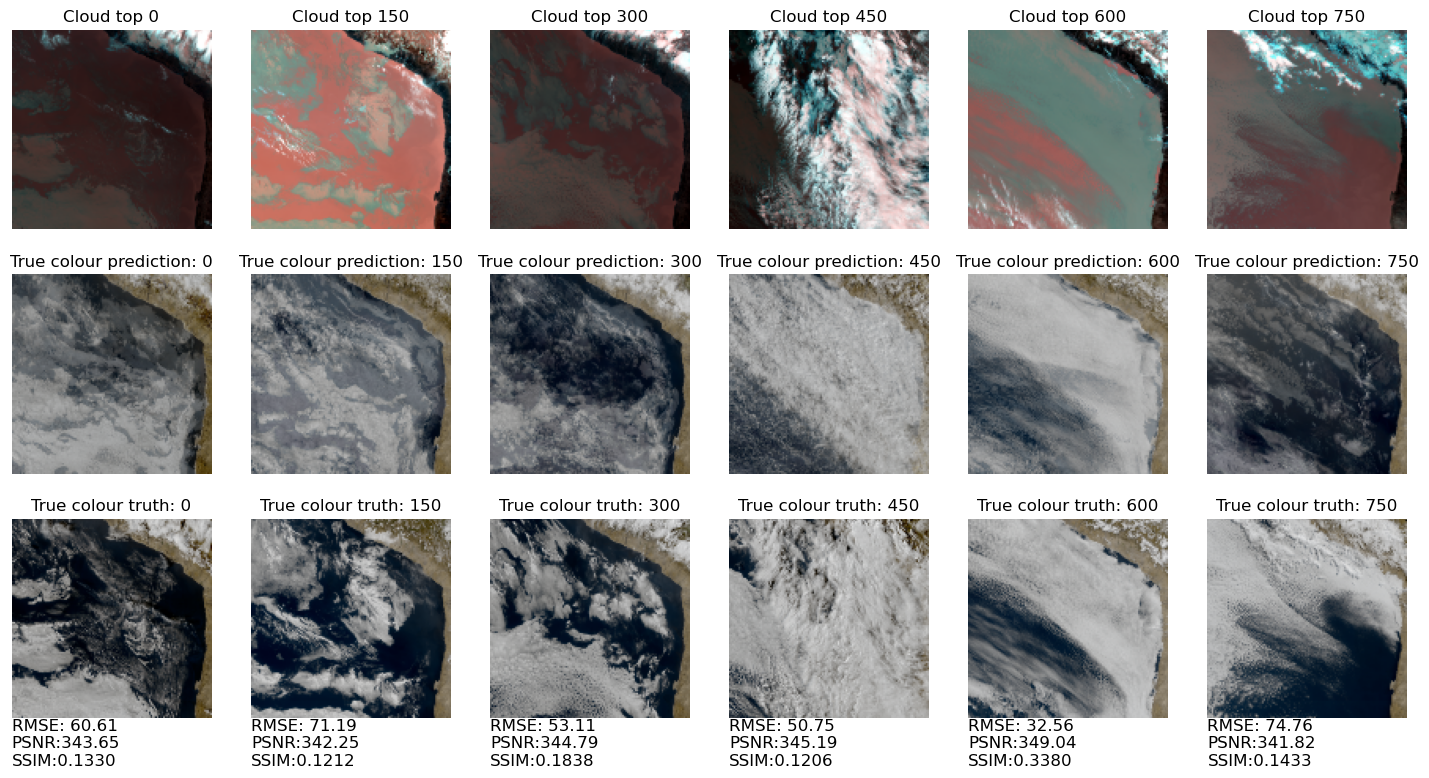

In [25]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))

for i in range(6):
    pred_img = kNN_prediction(cloudtop_test[i*150], 3)
    true_img = truecolour_test[i*150]

    
    axes[0, i].imshow(cloudtop_test[i*150])
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*150}')
    
    axes[1, i].imshow(pred_img)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'True colour prediction: {i*150}')

    axes[2, i].imshow(true_img)
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f'True colour truth: {i*150}')

    fig.text(
        *axes[2,i].get_position().bounds[0:2], 
        f'RMSE: {rmse(pred_img, true_img):.2f}' \
        f'\nPSNR:{psnr(pred_img, true_img):.2f}' \
        f'\nSSIM:{ssim(pred_img, true_img):.4f}',
        ha="left", va="top", fontsize=12
    )

In [26]:
test_rmse = []
test_psnr = []
test_ssim = []

for i in range(min(cloudtop_test.shape[0],200)):
    pred_img = kNN_prediction(cloudtop_test[i], 3)
    true_img = truecolour_test[i]

    test_rmse.append(rmse(pred_img, true_img))
    test_psnr.append(psnr(pred_img, true_img))
    test_ssim.append(ssim(pred_img, true_img))
    
print(f'Mean RMSE: {np.mean(test_rmse)}, \nMean PSNR: {np.mean(test_psnr)}, \nMean SSIM: {np.mean(test_ssim)}')

Mean RMSE: 59.1383561090458, 
Mean PSNR: 344.09452218755155, 
Mean SSIM: 0.15445585193176417


# CNN pipeline

In [28]:
import torch
from torch import nn
from lightning.pytorch import LightningModule

In [64]:
class Block(LightningModule):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [202]:
class Encoder(LightningModule):
    def __init__(self, channels=(32, 64, 128, 256, 512)):
        super().__init__()
        self.channels = channels
        self.enc_blocks = nn.ModuleList(
            [Block(3, self.channels[0])] + [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2, padding=1)
    
    def forward(self, x):
        x = self.enc_blocks[0](x)
        for block in self.enc_blocks[1:]:
            x = self.pool(x)
            x = block(x)
        return x
    

In [206]:
class Decoder(LightningModule):
    def __init__(self, channels=(512, 256, 128, 64, 32)):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[i], channels[i], 2, 2, padding=0) for i in range(len(channels)-1)
        ])
        self.dec_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)] + [Block(self.channels[-1], 3)]
        ) 
        
    def forward(self, x):
        for upconv, block in zip(self.upconvs, self.dec_blocks):
            x = upconv(x)[...,:-1,:-1]
            x = block(x)
        x = self.dec_blocks[-1](x)
        return x[...,1:-1,1:-1]

In [207]:
class Image2Image_CNN(LightningModule):
    def __init__(
        self, 
        encoder_channels=(32, 64, 128, 256, 512), 
        decoder_channels=(512, 256, 128, 64, 32), 
        learning_rate=1.5e-4,
        loss_function=nn.MSELoss()
    ):
        super().__init__()

        # TODO: replace predefined channels with depth

        # Define encoder and decoder
        self.encoder = Encoder(encoder_channels)
        self.decoder = Decoder(decoder_channels)

        # define & log hyperparameters
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.save_hyperparameters(ignore=['loss_function'])

        # loss function
        self.loss = loss_function

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def compute_loss(self, batch):
        image, target = batch
        # forward pass
        predictions = self(image).squeeze()
        # calculate loss
        loss = self.loss(predictions, target)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log training loss
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log validation loss
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log test loss
        self.log(
            "test_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss

In [208]:
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import LightningDataModule

class NightvisionDataset(Dataset):
    def __init__(self, cloudtop, truecolour):

        super().__init__()
        
        self.cloudtop = cloudtop
        self.truecolour = truecolour

    def __len__(self):
        return self.cloudtop.shape[0]
    
    def __getitem__(self, idx):
        return (
            np.clip(self.cloudtop[idx]/255, 0, 1).transpose([2,0,1]).astype(np.float32), 
            np.clip(self.truecolour[idx]/255, 0, 1).transpose([2,0,1]).astype(np.float32), 
        )

class NightvisionDataloader(LightningDataModule):
    def __init__(
        self, 
        batch_size, 
        truecolour_train, 
        truecolour_test, 
        truecolour_validate, 
        cloudtop_train, 
        cloudtop_test, 
        cloudtop_validate, 
        num_workers=10, 
    ):
        super().__init__()
        self.batch_size = batch_size

        # Get list of files for each split
        self.train_dataset = NightvisionDataset(
            cloudtop_train, truecolour_train, 
        )
        self.val_dataset = NightvisionDataset(
            cloudtop_validate, truecolour_validate, 
        )
        self.test_dataset = NightvisionDataset(
            cloudtop_test, truecolour_test, 
        )
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            pin_memory=True, 
            # num_workers=self.num_workers, 
            # persistent_workers=True, 
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            pin_memory=True, 
            # num_workers=self.num_workers, 
            # persistent_workers=True, 
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            pin_memory=True, 
            # num_workers=self.num_workers, 
            # persistent_workers=True, 
        )

In [209]:
dl = NightvisionDataloader(
    12, 
    truecolour_train, 
    truecolour_test, 
    truecolour_validate, 
    cloudtop_train, 
    cloudtop_test, 
    cloudtop_validate, 
)

In [210]:
dl.test_dataset[0][0].dtype

dtype('float32')

In [211]:
dl.test_dataloader()

In [212]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger

# Add a logger for metrics and checkpoints
csv_logger = CSVLogger(
    save_dir='',
    name='logs'
)

num_epochs = 2

In [213]:
def check_set_gpu(override=None):
    if override is None:
        if torch.cuda.is_available():
            device = torch.device('cuda')
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
            print(f"Using MPS: {torch.backends.mps.is_available()}")
        else:
            device = torch.device('cpu')
            print(f"Using CPU: {torch.device('cpu')}")
    else:
        device = torch.device(override)
    return device

In [214]:
cnn = Image2Image_CNN()

In [215]:
dl = NightvisionDataloader(
    24, 
    truecolour_train, 
    truecolour_test, 
    truecolour_validate, 
    cloudtop_train, 
    cloudtop_test, 
    cloudtop_validate, 
)

In [216]:
# Initialize the trainer
trainer = Trainer(
    max_epochs=10,
    callbacks=[TQDMProgressBar(refresh_rate=10)],
    logger=csv_logger,
    accelerator="auto"
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [217]:
trainer.fit(cnn, dl)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 4.7 M  | train
1 | decoder | Decoder | 3.7 M  | train
2 | loss    | MSELoss | 0      | train
--------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
33.831    Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:11<00:00,  4.79it/s, v_num=25, train_loss_step=0.0743]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█| 57/57 [00:11<00:00,  4.90it/s, v_num=25, train_loss_step=0.0598, val_loss_step=0.0628, val_loss_epoch=0.0676, train_loss_epoch=0.139]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:04<00:00, 13.04it/s]
Epoch 2: 100%|█| 57/57 [00:12<00:00,  4.70it/s, v_num=25, train_loss_step=0.0485, val_loss_step=0.0546, val_loss_epoch=0.0576, train_loss_epoch=0.0622
Validation: |                                                                                 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 57/57 [00:16<00:00,  3.50it/s, v_num=25, train_loss_step=0.0267, val_loss_step=0.0263, val_loss_epoch=0.0254, train_loss_epoch=0.0254


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████| 86/86 [37:12<00:00,  0.04it/s, v_num=23, train_loss_step=0.258]

                                                                                                                                                      

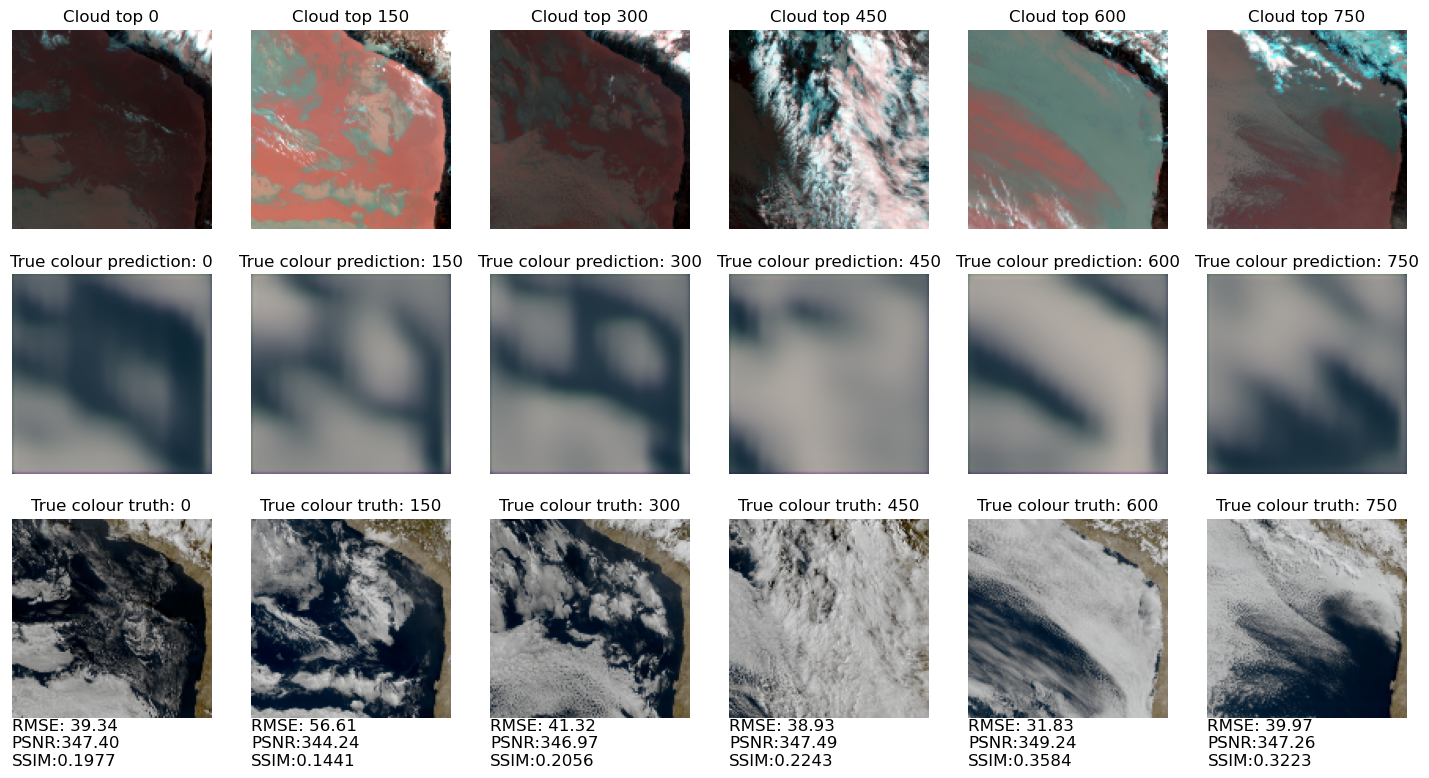

In [218]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))

def cnn_prediction(image):
    in_img = torch.from_numpy(
        (image.transpose(2,0,1)/255).astype(np.float32)
    )
    out_img = cnn.forward(in_img)
    out_img = out_img.detach().numpy().transpose(1,2,0)*255
    out_img = np.clip(out_img, 0, 255).astype(int)
    return out_img

for i in range(6):
    pred_img = cnn_prediction(cloudtop_test[i*150])
    true_img = truecolour_test[i*150]
    
    axes[0, i].imshow(cloudtop_test[i*150])
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*150}')
    
    axes[1, i].imshow(pred_img)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'True colour prediction: {i*150}')

    axes[2, i].imshow(true_img)
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f'True colour truth: {i*150}')

    fig.text(
        *axes[2,i].get_position().bounds[0:2], 
        f'RMSE: {rmse(pred_img, true_img):.2f}' \
        f'\nPSNR:{psnr(pred_img, true_img):.2f}' \
        f'\nSSIM:{ssim(pred_img, true_img):.4f}',
        ha="left", va="top", fontsize=12
    )

In [219]:
test_rmse = []
test_psnr = []
test_ssim = []

for i in range(min(cloudtop_test.shape[0],200)):
    pred_img = cnn_prediction(cloudtop_test[i])
    true_img = truecolour_test[i]

    test_rmse.append(rmse(pred_img, true_img))
    test_psnr.append(psnr(pred_img, true_img))
    test_ssim.append(ssim(pred_img, true_img))
    
print(f'Mean RMSE: {np.mean(test_rmse)}, \nMean PSNR: {np.mean(test_psnr)}, \nMean SSIM: {np.mean(test_ssim)}')

Mean RMSE: 43.82810574247505, 
Mean PSNR: 346.6184530902098, 
Mean SSIM: 0.21241892559942252


# U-Net pipeline

In [193]:
class UNetEncoder(LightningModule):
    def __init__(self, channels=(32, 64, 128, 256, 512)):
        super().__init__()
        self.channels = channels
        self.enc_blocks = nn.ModuleList(
            [Block(3, self.channels[0])] + [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2, padding=1)
    
    def forward(self, x):
        features = []
        
        x = self.enc_blocks[0](x)
        features.append(x)
        
        for block in self.enc_blocks[1:]:
            x = self.pool(x)
            x = block(x)
            features.append(x)
            
        return features
    
class UNetDecoder(LightningModule):
    def __init__(self, channels=(512, 256, 128, 64, 32)):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[i], channels[i+1], 2, 2, padding=0) for i in range(len(channels)-1)
        ])
        self.dec_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)] + [Block(self.channels[-1], 3)]
        ) 
        
    def forward(self, x, features):
        for upconv, block, feature in zip(self.upconvs, self.dec_blocks, features[::-1]):
            # import pdb
            # pdb.set_trace()
            x = upconv(x)
            H, W = feature.shape[2:]
            x = torch.cat([x[...,:H,:W], feature], dim=1)
            x = block(x)
        x = self.dec_blocks[-1](x)
        return x

class Image2Image_UNet(LightningModule):
    def __init__(
        self, 
        encoder_channels=(32, 64, 128, 256, 512), 
        decoder_channels=(512, 256, 128, 64, 32), 
        learning_rate=1.5e-4,
        loss_function=nn.MSELoss()
    ):
        super().__init__()

        # TODO: replace predefined channels with depth

        # Define encoder and decoder
        self.encoder = UNetEncoder(encoder_channels)
        self.decoder = UNetDecoder(decoder_channels)

        # define & log hyperparameters
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.save_hyperparameters(ignore=['loss_function'])

        # loss function
        self.loss = loss_function

    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(features[-1], features[:-1])
        return x

    def compute_loss(self, batch):
        image, target = batch
        # forward pass
        predictions = self(image).squeeze()
        # calculate loss
        loss = self.loss(predictions, target)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log training loss
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log validation loss
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        # log test loss
        self.log(
            "test_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True
        )
        return loss

In [194]:
unet = Image2Image_UNet()

In [195]:
[x.shape for x in unet.encoder(
    torch.from_numpy(dl.train_dataset[0][0])
)]

[torch.Size([32, 127, 127]),
 torch.Size([64, 64, 64]),
 torch.Size([128, 33, 33]),
 torch.Size([256, 17, 17]),
 torch.Size([512, 9, 9])]

In [196]:
unet.forward(
    torch.from_numpy(dl.train_dataset[0][0][np.newaxis])
)

tensor([[[[0.0871, 0.0831, 0.0847,  ..., 0.0843, 0.0851, 0.0878],
          [0.0843, 0.0770, 0.0815,  ..., 0.0796, 0.0804, 0.0847],
          [0.0803, 0.0739, 0.0785,  ..., 0.0757, 0.0781, 0.0846],
          ...,
          [0.0808, 0.0743, 0.0790,  ..., 0.0790, 0.0803, 0.0854],
          [0.0808, 0.0749, 0.0794,  ..., 0.0796, 0.0809, 0.0858],
          [0.0842, 0.0806, 0.0836,  ..., 0.0838, 0.0847, 0.0873]],

         [[0.1374, 0.1355, 0.1343,  ..., 0.1340, 0.1341, 0.1352],
          [0.1399, 0.1351, 0.1322,  ..., 0.1322, 0.1343, 0.1322],
          [0.1385, 0.1334, 0.1294,  ..., 0.1295, 0.1305, 0.1294],
          ...,
          [0.1385, 0.1330, 0.1287,  ..., 0.1298, 0.1310, 0.1301],
          [0.1386, 0.1326, 0.1289,  ..., 0.1294, 0.1299, 0.1299],
          [0.1390, 0.1356, 0.1323,  ..., 0.1328, 0.1333, 0.1339]],

         [[0.0620, 0.0694, 0.0681,  ..., 0.0684, 0.0668, 0.0673],
          [0.0658, 0.0737, 0.0703,  ..., 0.0711, 0.0717, 0.0686],
          [0.0647, 0.0762, 0.0716,  ..., 0

In [197]:
# Initialize the trainer
trainer = Trainer(
    max_epochs=10,
    callbacks=[TQDMProgressBar(refresh_rate=10)],
    logger=csv_logger,
    accelerator="auto"
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [198]:
trainer.fit(unet, dl)

/Users/jonesw/miniforge3/envs/iecdt-earth-obs/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/version_24/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | UNetEncoder | 4.7 M  | train
1 | decoder | UNetDecoder | 3.0 M  | train
2 | loss    | MSELoss     | 0      | train
------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.044    Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                                              | 0/? [00:00<?, ?it/s]

/Users/jonesw/miniforge3/envs/iecdt-earth-obs/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


/Users/jonesw/miniforge3/envs/iecdt-earth-obs/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████| 57/57 [00:11<00:00,  4.84it/s, v_num=24, train_loss_step=0.124]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████| 57/57 [00:10<00:00,  5.43it/s, v_num=24, train_loss_step=0.117, val_loss_step=0.119, val_loss_epoch=0.129, train_loss_epoch=0.176]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████| 57/57 [00:10<00:00,  5.38it/s, v_num=24, train_loss_step=0.128, val_loss_step=0.114, val_loss_epoch=0.123, train_loss_epoch=0.126]
Validation: |                                                                                                                   | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████| 57/57 [00:10<00:00,  5.44it/s, v_num=24, train_loss_step=0.116, val_loss_s

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 57/57 [00:14<00:00,  3.94it/s, v_num=24, train_loss_step=0.0237, val_loss_step=0.0215, val_loss_epoch=0.0246, train_loss_epoch=0.0301


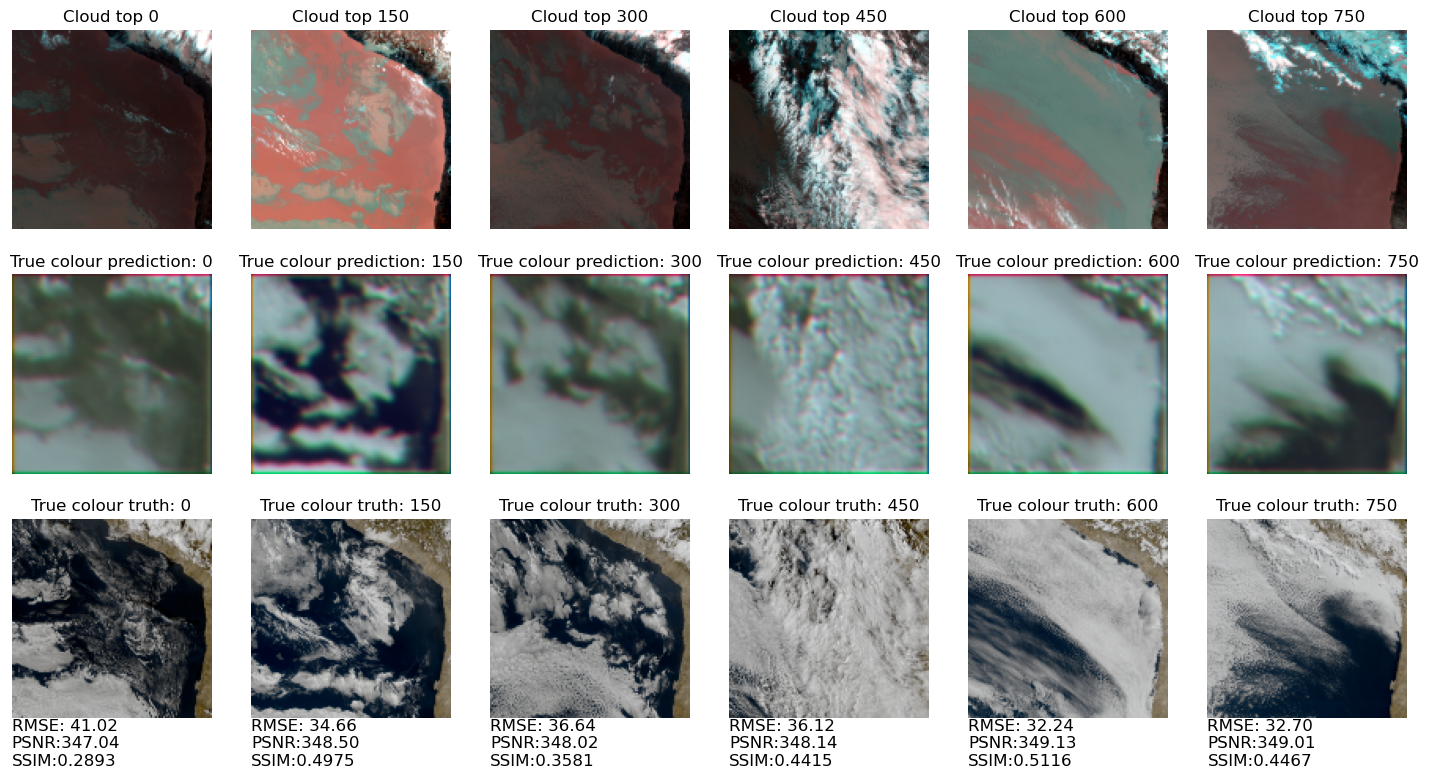

In [201]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))

def unet_prediction(image):
    in_img = torch.from_numpy(
        (image.transpose(2,0,1)/255).astype(np.float32)[np.newaxis]
    )
    out_img = unet.forward(in_img)
    out_img = out_img.detach().numpy().squeeze().transpose(1,2,0)*255
    out_img = np.clip(out_img, 0, 255).astype(int)
    return out_img

for i in range(6):
    pred_img = unet_prediction(cloudtop_test[i*150])
    true_img = truecolour_test[i*150]
    
    axes[0, i].imshow(cloudtop_test[i*150])
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f'Cloud top {i*150}')
    
    axes[1, i].imshow(pred_img)
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'True colour prediction: {i*150}')

    axes[2, i].imshow(true_img)
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f'True colour truth: {i*150}')

    fig.text(
        *axes[2,i].get_position().bounds[0:2], 
        f'RMSE: {rmse(pred_img, true_img):.2f}' \
        f'\nPSNR:{psnr(pred_img, true_img):.2f}' \
        f'\nSSIM:{ssim(pred_img, true_img):.4f}',
        ha="left", va="top", fontsize=12
    )

In [220]:
test_rmse = []
test_psnr = []
test_ssim = []

for i in range(min(cloudtop_test.shape[0],200)):
    pred_img = unet_prediction(cloudtop_test[i])
    true_img = truecolour_test[i]

    test_rmse.append(rmse(pred_img, true_img))
    test_psnr.append(psnr(pred_img, true_img))
    test_ssim.append(ssim(pred_img, true_img))
    
print(f'Mean RMSE: {np.mean(test_rmse)}, \nMean PSNR: {np.mean(test_psnr)}, \nMean SSIM: {np.mean(test_ssim)}')

Mean RMSE: 40.63985256772617, 
Mean PSNR: 347.31531686398813, 
Mean SSIM: 0.38727818736096553
